Importamos las librerias necesarias para el EDA

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Carga de los datos

In [3]:
df_viajes= pd.read_parquet('Datasets\Finales\yellow_tripdata_2023-04 (1).parquet')

In [4]:
df_viajes= df_viajes[['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
                      'passenger_count', 'trip_distance', 'payment_type', 'total_amount']]

In [5]:
df_viajes.drop(df_viajes[df_viajes['trip_distance'] == 0].index, inplace=True)
df_viajes.drop(df_viajes[df_viajes['total_amount'] <= 0].index, inplace=True)

In [6]:
df_viajes.drop_duplicates()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,total_amount
0,1,2023-04-01 00:14:49,2023-04-01 00:45:01,2.0,4.90,1,39.90
1,2,2023-04-01 00:00:24,2023-04-01 00:56:19,1.0,21.89,2,81.80
2,1,2023-04-01 00:03:50,2023-04-01 00:14:42,2.0,1.30,1,18.40
3,1,2023-04-01 00:53:18,2023-04-01 01:01:28,1.0,1.50,1,16.00
4,2,2023-04-01 00:07:00,2023-04-01 00:17:16,2.0,1.49,1,17.40
...,...,...,...,...,...,...,...
3288244,2,2023-04-30 23:13:02,2023-04-30 23:52:17,NaN,18.17,0,91.25
3288245,2,2023-04-30 23:50:19,2023-05-01 00:06:11,NaN,2.02,0,18.49
3288246,2,2023-04-30 23:28:32,2023-04-30 23:38:32,NaN,2.36,0,17.19
3288247,2,2023-04-30 23:25:26,2023-04-30 23:44:16,NaN,4.64,0,21.90


In [7]:
df_pollution= pd.read_csv('Datasets\Finales\pollution.csv')

Por una cuestion de memoria y capacidad, decidi realizar el modelo de machine learning sobre una muestra de los datos de 5000 registros.

In [8]:
total_filas = len(df_viajes)

indices_seleccionados = random.sample(range(total_filas), 5000)

df_trips_muestra = df_viajes.iloc[indices_seleccionados]

In [9]:
#Proportion (percentage over 100):
combustion = 35
hybrid = 50
electric = 15

# Total vehicles = 26
prop_combustion = combustion//17
prop_hybrid = hybrid//4
prop_electric = electric//5

# Create a new column in the table df_pollution with the proportion of each vehicle in the database
df_pollution['proportion'] = df_pollution.loc[df_pollution['Fuel Type'] == 'X', 'proportion'] = prop_combustion
df_pollution.loc[df_pollution['Fuel Type'] == 'Z', 'proportion'] = prop_combustion
df_pollution.loc[df_pollution['Fuel Type'] == 'B/X*', 'proportion'] = prop_hybrid
df_pollution.loc[df_pollution['Fuel Type'] == 'B', 'proportion'] = prop_electric

asignacion_aleatoria = random.choices(df_pollution['Vehicle_id'], weights=df_pollution['proportion'], k=5000)

df_trips_muestra['Vehicle_id'] = asignacion_aleatoria

C:\Users\Dell\AppData\Local\Temp\ipykernel_11588\767234263.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trips_muestra['Vehicle_id'] = asignacion_aleatoria


In [10]:
df_trips_muestra= df_trips_muestra.merge(df_pollution, on= 'Vehicle_id')

Primera visualizacion de datos con metodos como: head(), info(), describe()

In [ ]:
df_trips_muestra.head()

In [ ]:
df_trips_muestra.info()

In [ ]:
df_trips_muestra.describe()

Busqueda de nulos 

In [254]:
print(df_trips_muestra.isnull().sum())  

VendorID                            0
tpep_pickup_datetime                0
tpep_dropoff_datetime               0
passenger_count                   130
trip_distance                       0
payment_type                        0
total_amount                        0
Vehicle_id                          0
Fuel Type                           0
Consumption Comb (Le/100 km)        0
Consumption Comb (kWh/100 km)    1801
Recharge Time (h)                1801
CO2 Emissions (g/km)                0
dB_at_80kmh                         0
proportion                          0
dtype: int64


In [11]:
#Rellenar los nulos con la media

df_trips_muestra['passenger_count'].mean()

df_trips_muestra['passenger_count'].fillna(1, inplace=True)

In [79]:
df_trips_muestra.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'payment_type', 'total_amount',
       'Vehicle_id', 'Fuel Type', 'Consumption Comb (Le/100 km)',
       'Consumption Comb (kWh/100 km)', 'Recharge Time (h)',
       'CO2 Emissions (g/km)', 'dB_at_80kmh', 'proportion'],
      dtype='object')

Presentacion de histogramas para algunas variables numericas claves.

<Axes: >

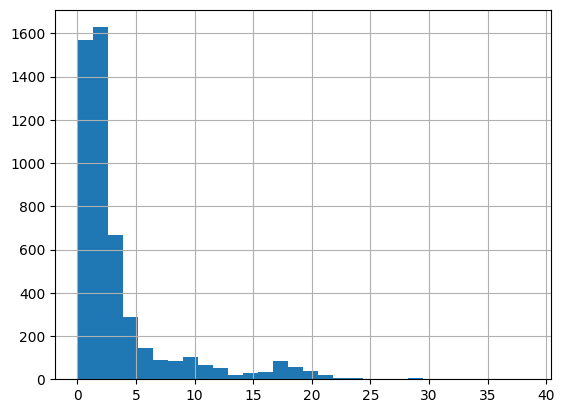

In [94]:
#"trip_distance" 
df_trips_muestra['trip_distance'].hist(bins=30) 

<Axes: >

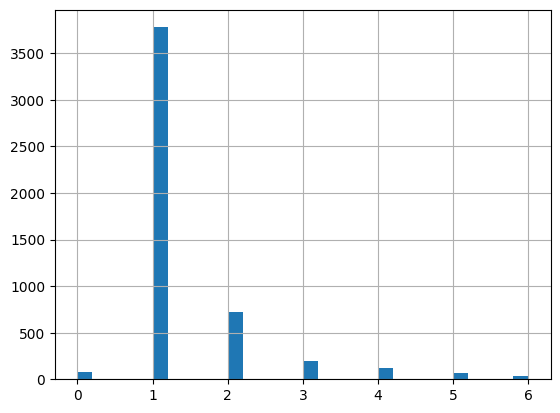

In [101]:
#"release_year" 
df_trips_muestra['passenger_count'].hist(bins=30) 

Presentacion de un mapa de calor asociado a la matriz de correlacion.

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1403927953.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


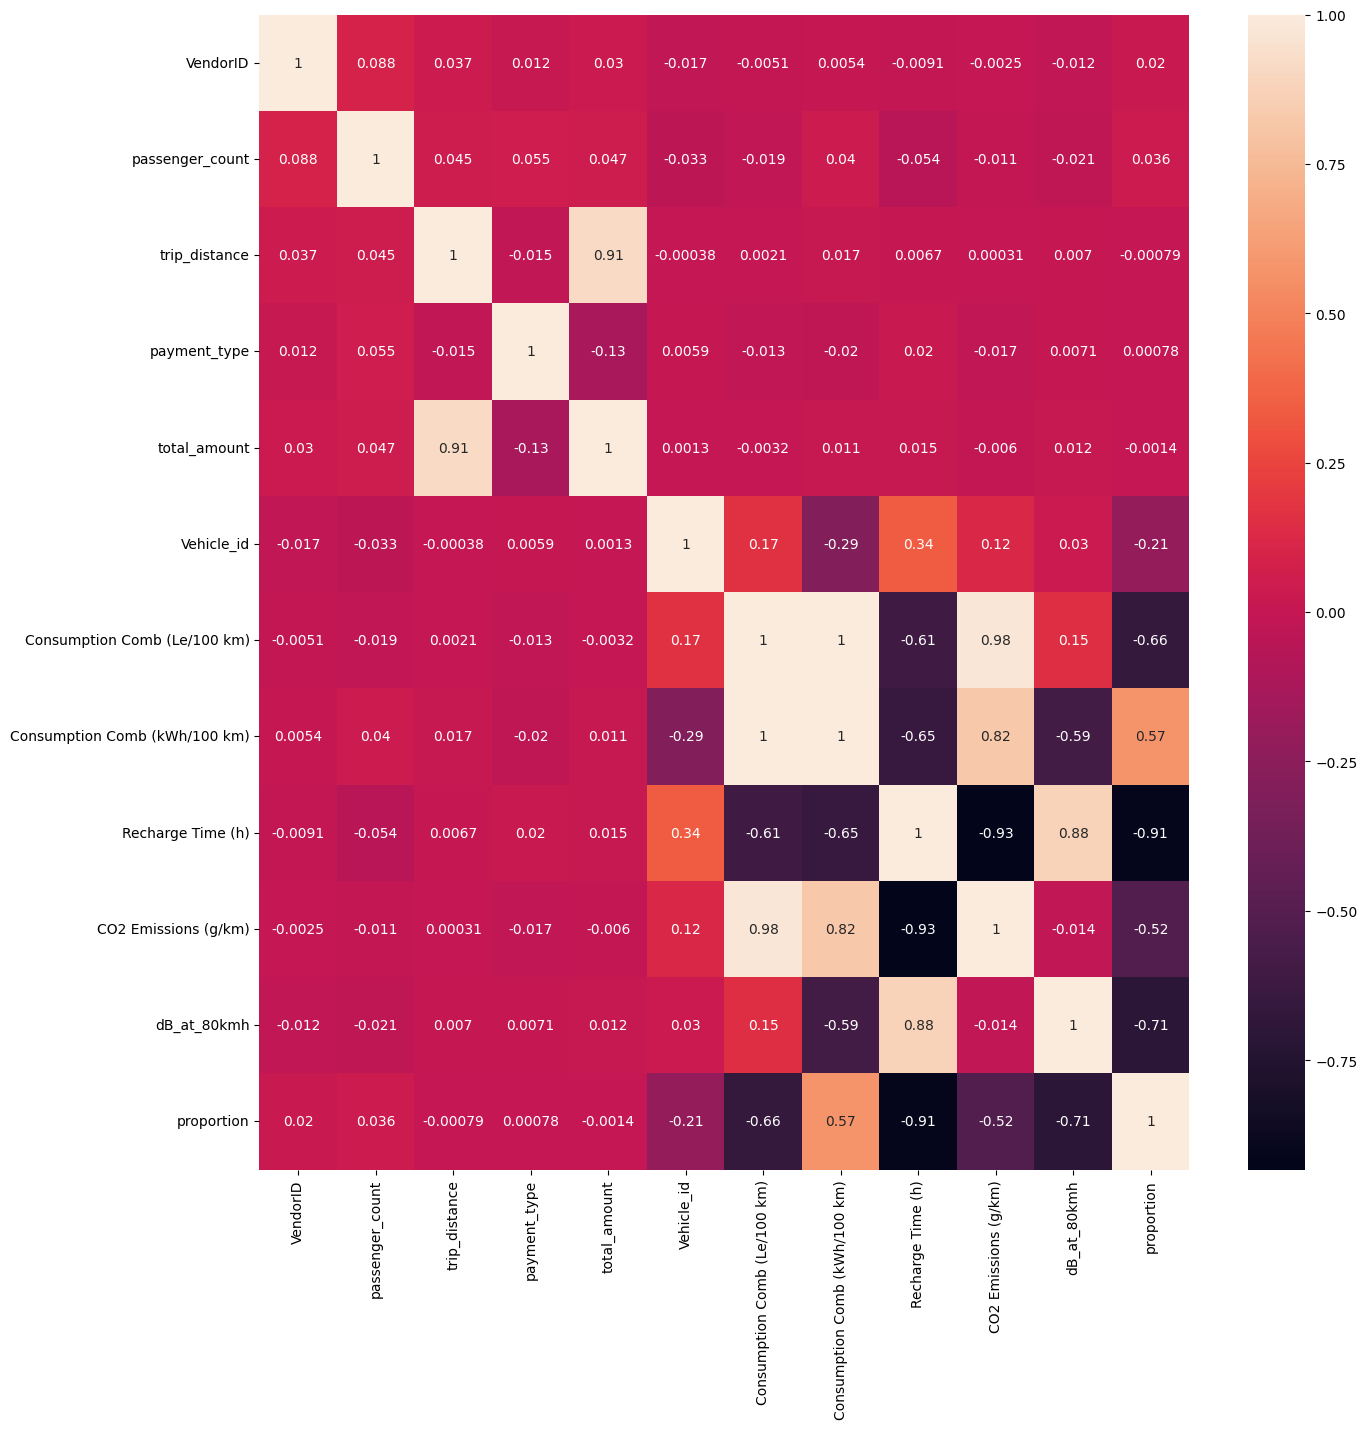

In [102]:
#Variables numericas importantes
df = df_trips_muestra

#Calculo de matriz de correlacion
corr_matrix = df.corr() 
plt.figure(figsize=(15,15))
#Diseño de mapa de calor
sns.heatmap(corr_matrix, annot=True) 
plt.show()

In [12]:
df_trips_muestra['co2_total']= df_trips_muestra['trip_distance'] * df_trips_muestra['CO2 Emissions (g/km)']

In [118]:
df_trips_muestra.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,total_amount,Vehicle_id,Fuel Type,Consumption Comb (Le/100 km),Consumption Comb (kWh/100 km),Recharge Time (h),CO2 Emissions (g/km),dB_at_80kmh,proportion,co2_total
0,2,2023-04-01 10:06:41,2023-04-01 10:22:25,2.0,5.50,1,34.44,23,X,7.9,NaN,NaN,184.0,62.5,2,1012.00
1,2,2023-04-20 22:43:20,2023-04-20 22:47:14,1.0,0.97,1,13.80,23,X,7.9,NaN,NaN,184.0,62.5,2,178.48
2,2,2023-04-20 22:45:54,2023-04-20 23:08:14,1.0,3.07,1,26.90,23,X,7.9,NaN,NaN,184.0,62.5,2,564.88
3,2,2023-04-24 07:41:50,2023-04-24 07:54:30,1.0,2.59,1,21.74,23,X,7.9,NaN,NaN,184.0,62.5,2,476.56
4,2,2023-04-28 10:43:17,2023-04-28 11:14:31,1.0,10.35,1,72.05,23,X,7.9,NaN,NaN,184.0,62.5,2,1904.40


In [258]:
# Ahora veamos algunas estadísticas de nuestros datos
df_trips_muestra.describe()

,VendorID,passenger_count,trip_distance,payment_type,total_amount,Vehicle_id,Consumption Comb (Le/100 km),Consumption Comb (kWh/100 km),Recharge Time (h),CO2 Emissions (g/km),dB_at_80kmh,proportion,co2_total
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,3199.000000,3199.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,1.742200,1.394400,3.613524,1.175800,28.803666,12.306800,4.118320,21.149859,4.231572,86.702200,60.442852,7.04440,317.701404
std,0.437467,0.909403,4.595299,0.488817,22.256176,8.108824,2.588262,2.784045,2.083200,69.860578,3.098580,4.86304,579.852385
min,1.000000,0.000000,0.010000,0.000000,1.000000,1.000000,1.800000,15.800000,2.000000,0.000000,57.300000,2.00000,0.000000
25%,1.000000,1.000000,1.110000,1.000000,15.960000,4.000000,2.300000,19.200000,2.800000,42.000000,58.325000,2.00000,47.070000
50%,2.000000,1.000000,1.870000,1.000000,21.000000,12.000000,2.500000,20.600000,3.400000,49.000000,58.325000,3.00000,127.865000
75%,2.000000,1.000000,3.620000,1.000000,30.240000,20.000000,6.600000,22.300000,4.500000,154.000000,62.500000,12.00000,332.965000
max,2.000000,6.000000,42.590000,4.000000,252.900000,26.000000,11.600000,25.800000,8.500000,271.000000,67.200000,12.00000,6485.030000


Predecir contaminacion futura basados en: co2_total

In [14]:
data_contaminacion= df_trips_muestra[['co2_total','Fuel Type', 'CO2 Emissions (g/km)', 'trip_distance']]

Modelo de regresión lineal general

C:\Users\Dell\AppData\Local\Temp\ipykernel_11588\1508699748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_contaminacion['co2_Log'] = np.log1p(data_contaminacion['co2_total'])


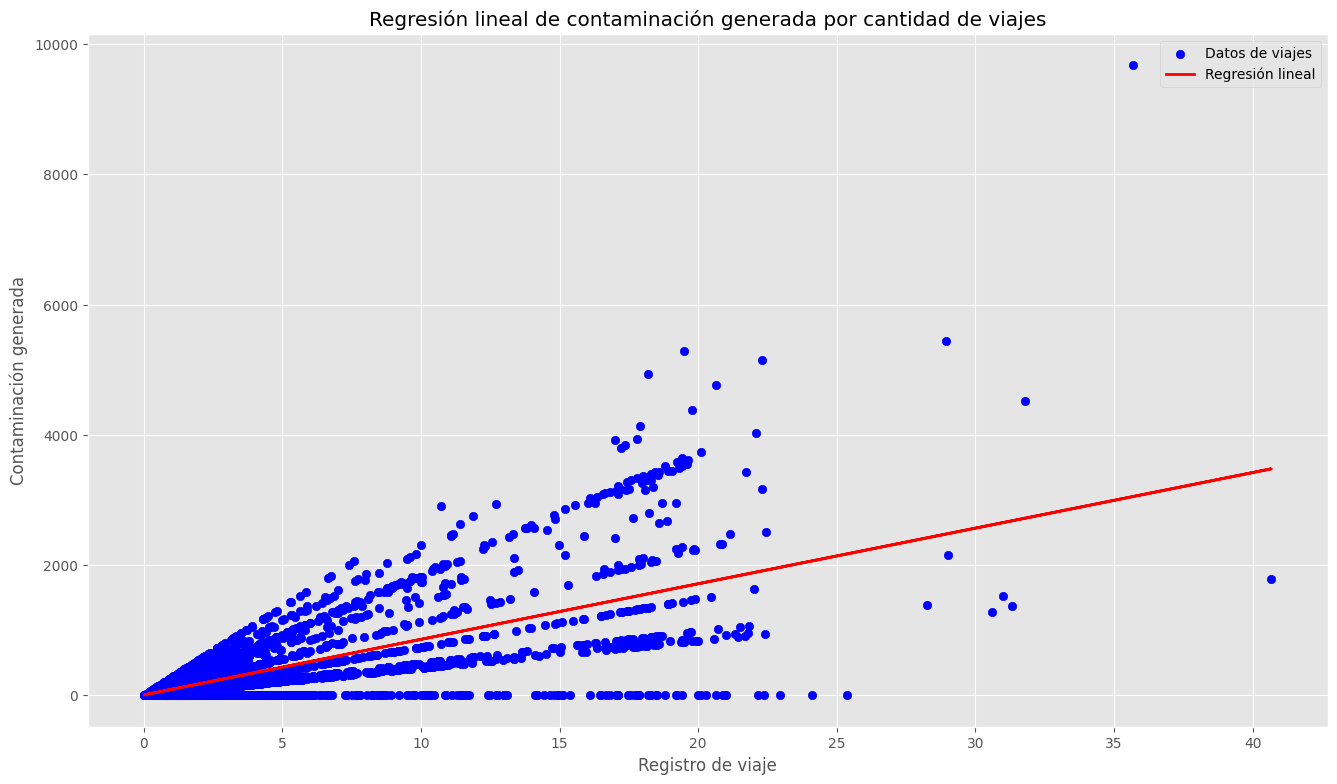

In [19]:
from sklearn.linear_model import LinearRegression

# Aplicar la transformación logarítmica modificada a las emisiones de CO2
data_contaminacion['co2_Log'] = np.log1p(data_contaminacion['co2_total'])

# Preparar los datos
X = data_contaminacion['trip_distance'].values.reshape(-1, 1)  # Variable independiente (número de fila)
y = data_contaminacion['co2_total'].values   # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Contaminación generada')
plt.title('Regresión lineal de contaminación generada por cantidad de viajes')
plt.legend()
plt.show()


Modelo de regresión lineal para modelos de combustion

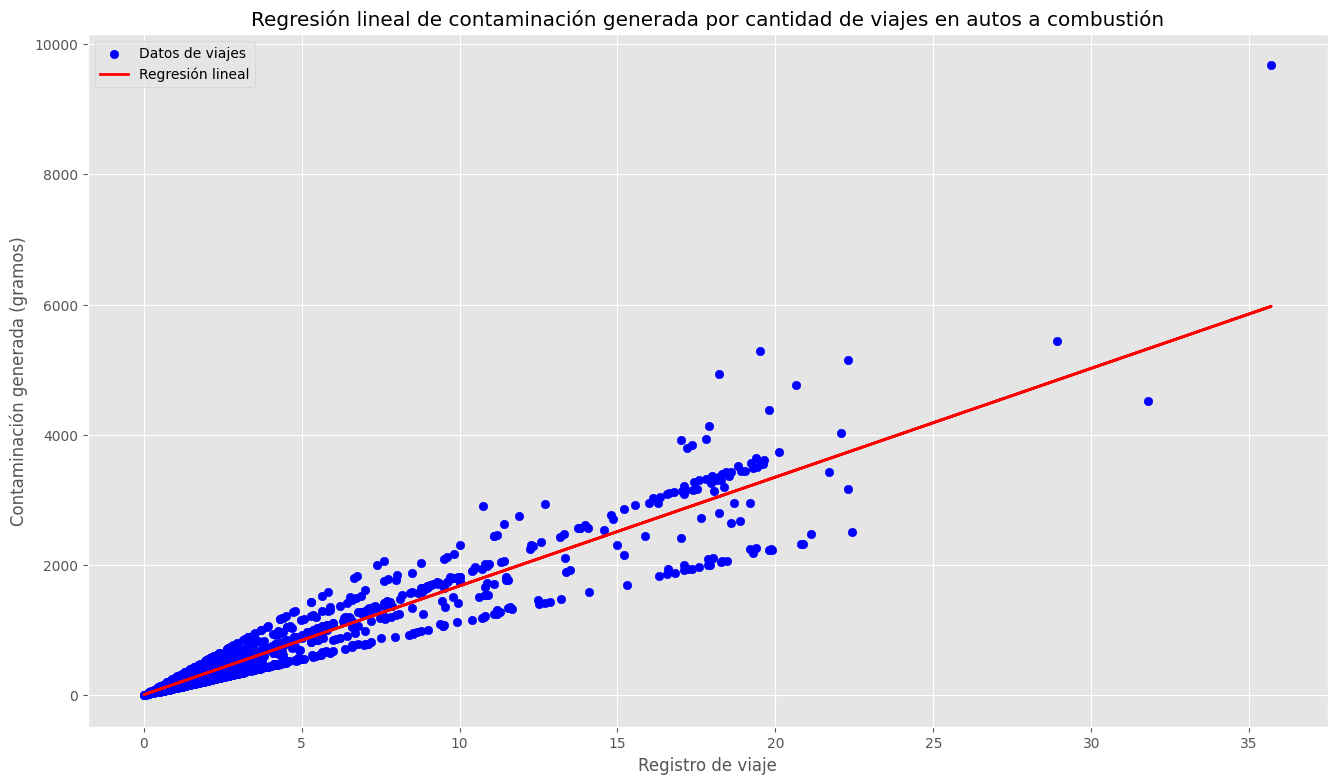

In [20]:
# Filtrar las filas que tienen el valor 'X' en la columna 'Fuel Type'
df_combustion = data_contaminacion.loc[(data_contaminacion['Fuel Type']== 'X') 
                                       |(data_contaminacion['Fuel Type']== 'Z')]

df_combustion.reset_index(inplace=True)

# Preparar los datos
X = df_combustion['trip_distance'].values.reshape(-1, 1)  # Variable independiente (número de fila)
y = df_combustion['co2_total'].values   # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Contaminación generada (gramos)')
plt.title('Regresión lineal de contaminación generada por cantidad de viajes en autos a combustión')
plt.legend()
plt.show()


Modelo de regresión lineal para modelos hibridos

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\998402905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hibridos['co2_Log'] = np.log1p(df_hibridos['co2_total'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\998402905.py:21: RuntimeWarning: overflow encountered in expm1
  y_original = np.expm1(y_pred)


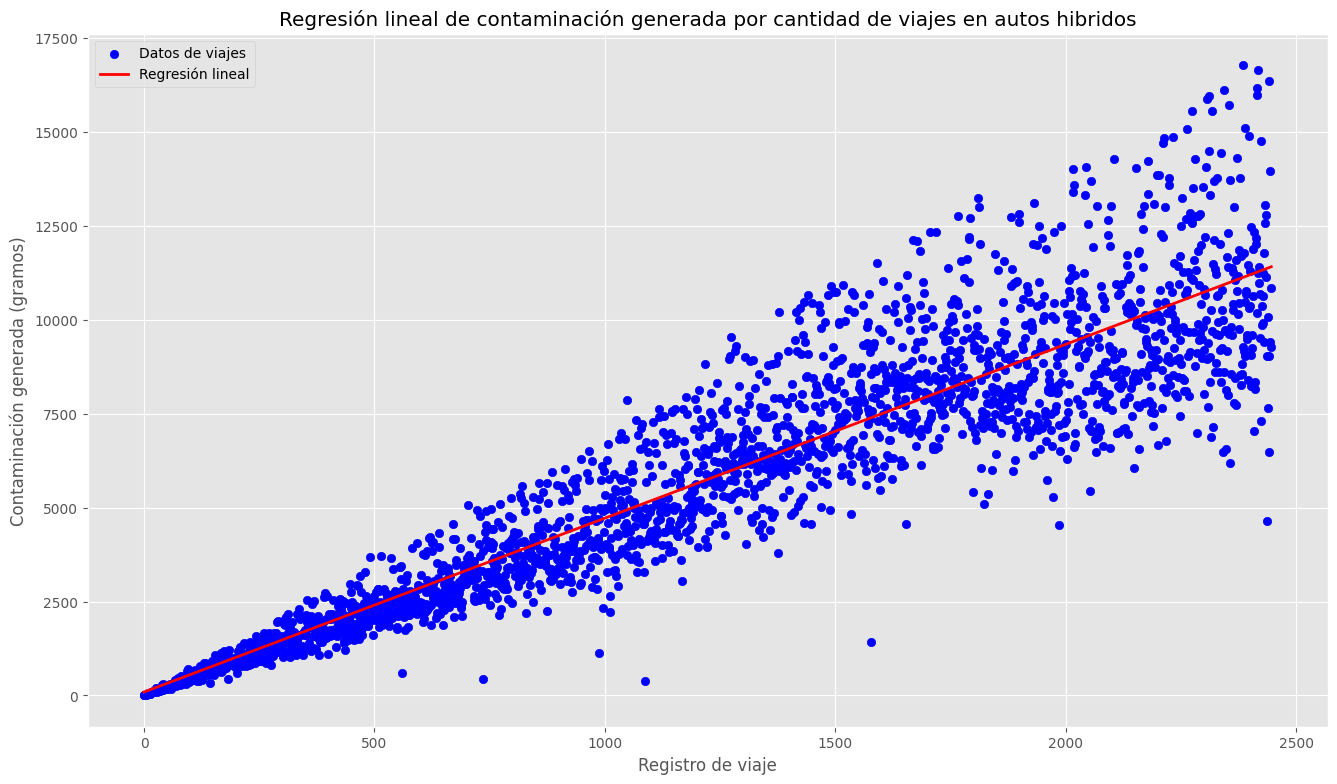

In [262]:
# Filtrar las filas que tienen el valor 'X' en la columna 'Fuel Type'
df_hibridos = data_contaminacion.loc[data_contaminacion['Fuel Type']== 'B/X*']

df_hibridos.reset_index(inplace=True)

# Aplicar la transformación logarítmica modificada a las emisiones de CO2
df_hibridos['co2_Log'] = np.log1p(df_hibridos['co2_total'])

# Preparar los datos
X = df_hibridos.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = df_hibridos['co2_Log'].values * (df_hibridos.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Convertir los valores transformados a la unidad original en gramos
y_original = np.expm1(y_pred)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Contaminación generada (gramos)')
plt.title('Regresión lineal de contaminación generada por cantidad de viajes en autos hibridos')
plt.legend()
plt.show()

Modelo de regresión lineal para modelos electricos

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1540827377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electricos['co2_Log'] = np.log1p(df_electricos['co2_total'])


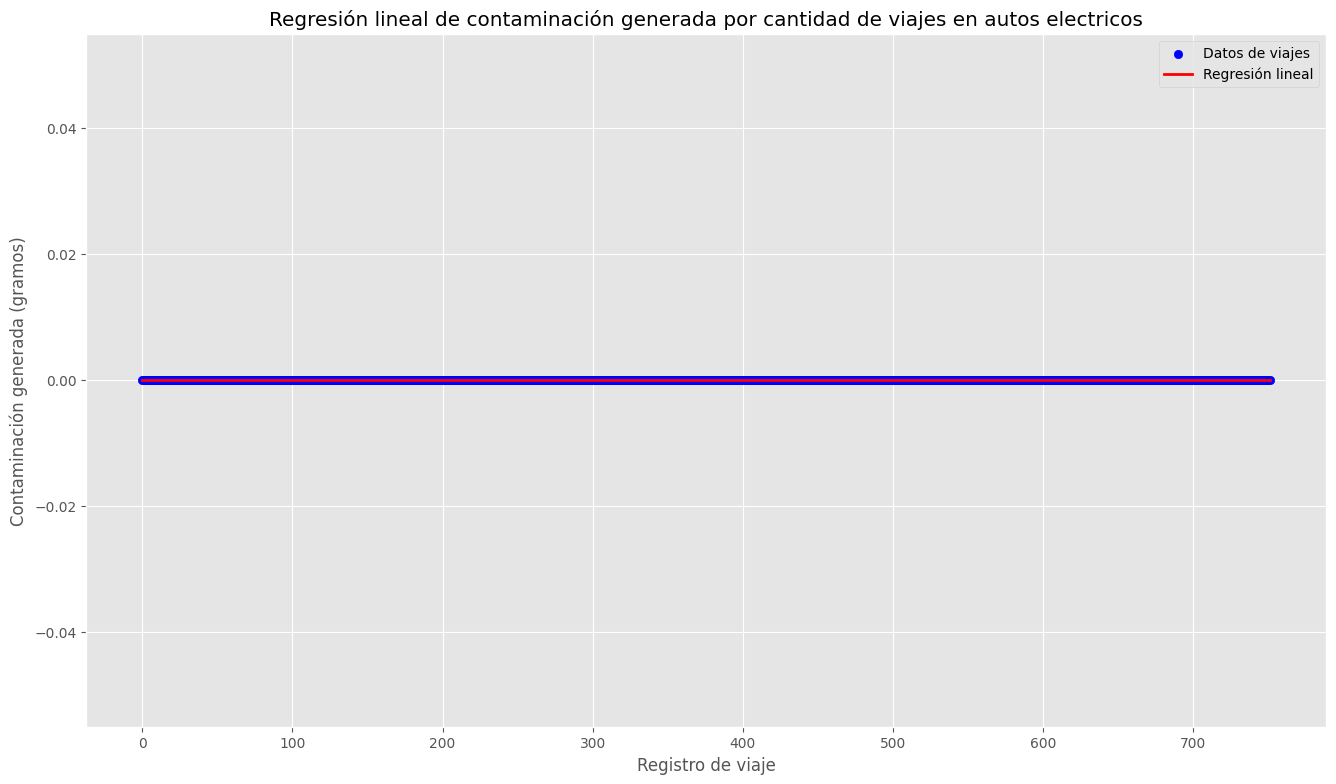

In [263]:
# Filtrar las filas que tienen el valor 'X' en la columna 'Fuel Type'
df_electricos = data_contaminacion.loc[data_contaminacion['Fuel Type']== 'B']

df_electricos.reset_index(inplace=True)

# Aplicar la transformación logarítmica modificada a las emisiones de CO2
df_electricos['co2_Log'] = np.log1p(df_electricos['co2_total'])

# Preparar los datos
X = df_electricos.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = df_electricos['co2_Log'].values * (df_electricos.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Convertir los valores transformados a la unidad original en gramos
y_original = np.expm1(y_pred)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Contaminación generada (gramos)')
plt.title('Regresión lineal de contaminación generada por cantidad de viajes en autos electricos')
plt.legend()
plt.show()

In [264]:
data_economica= df_trips_muestra[['total_amount', 'Fuel Type', 'trip_distance',
                                  'Consumption Comb (Le/100 km)',
                                  'Consumption Comb (kWh/100 km)', 'Recharge Time (h)']]

data_economica['Consumo_total']= 0
data_economica['Costo']=0

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\3554728472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_economica['Consumo_total']= 0
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\3554728472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_economica['Costo']=0


Establecer consumo y costo de modelos electricos

In [265]:
data_economica.loc[data_economica['Fuel Type'] == 'B', 
'Consumo_total']= data_economica['trip_distance'] * (data_economica['Consumption Comb (kWh/100 km)'] / 100)

In [266]:
data_economica.loc[data_economica['Fuel Type'] == 'B', 
'Costo']= data_economica['Consumo_total']* 16.8

Establecer consumo y costo de modelos a combustion

In [267]:
data_economica.loc[(data_economica['Fuel Type'] == 'X') | (data_economica['Fuel Type'] == 'Z'), 
'Consumo_total']= data_economica['trip_distance'] * (data_economica['Consumption Comb (Le/100 km)'] / 100)

In [268]:
data_economica.loc[(data_economica['Fuel Type'] == 'X') | (data_economica['Fuel Type'] == 'Z'),
'Costo']= data_economica['Consumo_total']* 3.361

Establecer consumo y costo de modelos hibridos

In [269]:
data_economica.loc[(data_economica['Fuel Type'] == 'B/X*'), 'Consumo_total']=\
data_economica['trip_distance'] * (data_economica['Consumption Comb (kWh/100 km)'] / 100)

In [270]:
data_economica.loc[(data_economica['Fuel Type'] == 'B/X*'),'Costo']=\
                    data_economica['Consumo_total']* 16.8

In [ ]:
data_economica['Ganancia']= data_economica['total_amount'] - data_economica['Costo']

In [288]:
data_economica.head()

,total_amount,Fuel Type,trip_distance,Consumption Comb (Le/100 km),Consumption Comb (kWh/100 km),Recharge Time (h),Consumo_total,Costo,Ganancia,Ganancia_log
0,23.52,B,2.57,2.1,18.6,7.5,0.47802,8.030736,15.489264,2.802710
1,16.00,B,0.90,2.1,18.6,7.5,0.16740,2.812320,13.187680,2.652374
2,15.00,B,1.20,2.1,18.6,7.5,0.22320,3.749760,11.250240,2.505546
3,27.70,B,2.96,2.1,18.6,7.5,0.55056,9.249408,18.450592,2.967878
4,24.50,B,1.76,2.1,18.6,7.5,0.32736,5.499648,19.000352,2.995750


Regresion lineal simple con columna ganancia, modelo general

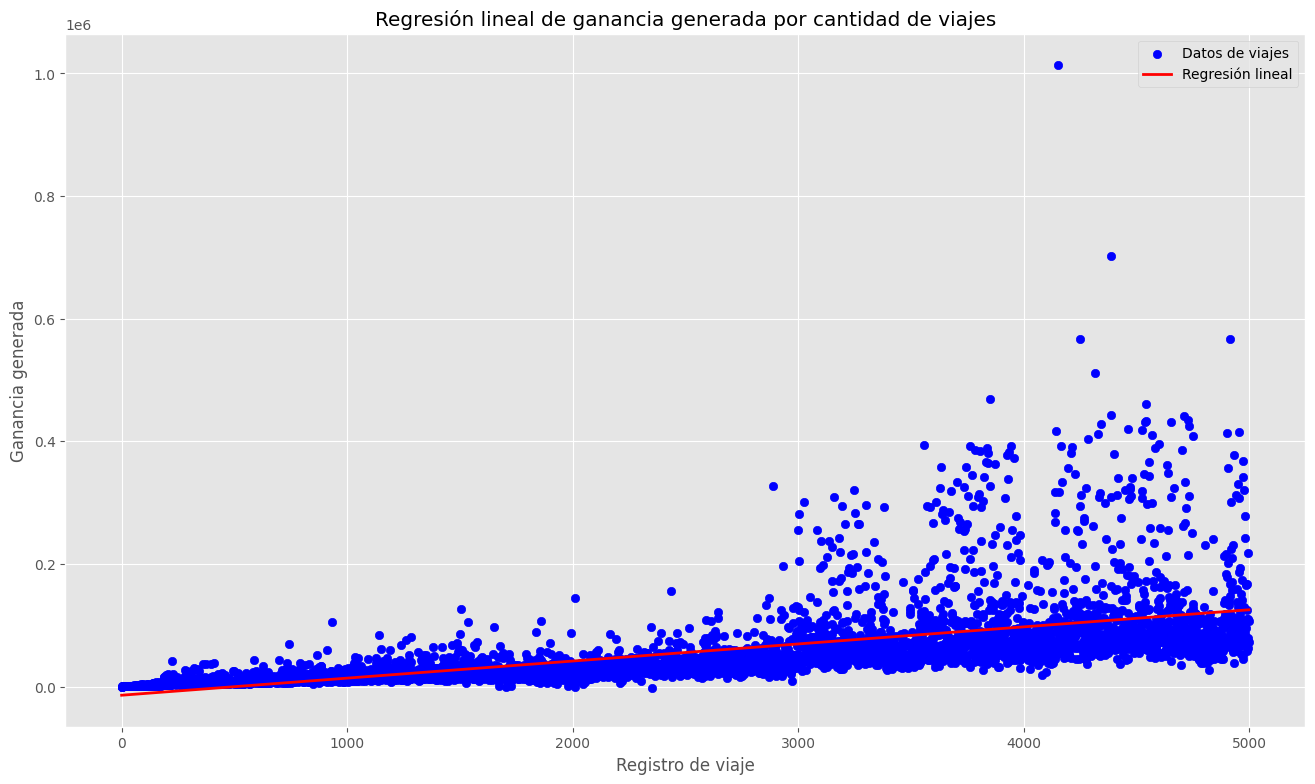

In [281]:
# Preparar los datos
X = data_economica.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = data_economica['Ganancia'].values * (data_economica.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Ganancia generada')
plt.title('Regresión lineal de ganancia generada por cantidad de viajes')
plt.legend()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\536793949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_economica['Ganancia_log'] = np.log1p(data_economica['Ganancia'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\536793949.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_economica.dropna(subset=['Ganancia_log'], inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\536793949.py:23: RuntimeWarning: overflow encountered in expm1
  y_original = np.expm1(y_pred)


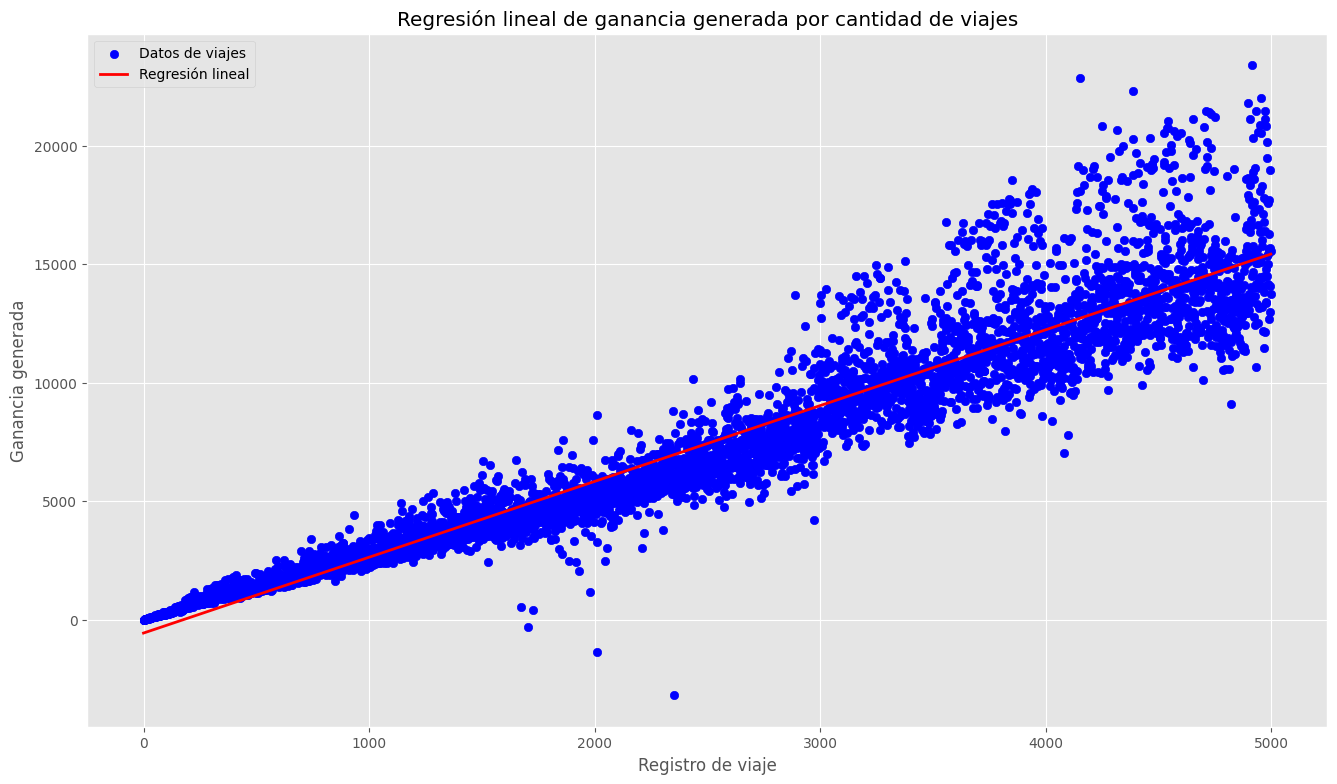

In [280]:
# Aplicar la transformación logarítmica modificada a las emisiones de CO2
data_economica['Ganancia_log'] = np.log1p(data_economica['Ganancia'])

# Eliminar filas con valores NaN en 'Ganancia_log'
data_economica.dropna(subset=['Ganancia_log'], inplace=True)

# Preparar los datos
X = data_economica.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = data_economica['Ganancia_log'].values * (data_economica.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Convertir los valores transformados a la unidad original en gramos
y_original = np.expm1(y_pred)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Ganancia generada')
plt.title('Regresión lineal de ganancia generada por cantidad de viajes')
plt.legend()
plt.show()

Regresión lineal simple para autos de combustion:

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\2772537858.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combustion['Ganancia_log'] = np.log1p(df_combustion['Ganancia'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\2772537858.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combustion.dropna(subset=['Ganancia_log'], inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\2772537858.py:29: RuntimeWarning: overflow encountered in expm1
  y_original = np.expm1(y_pred)


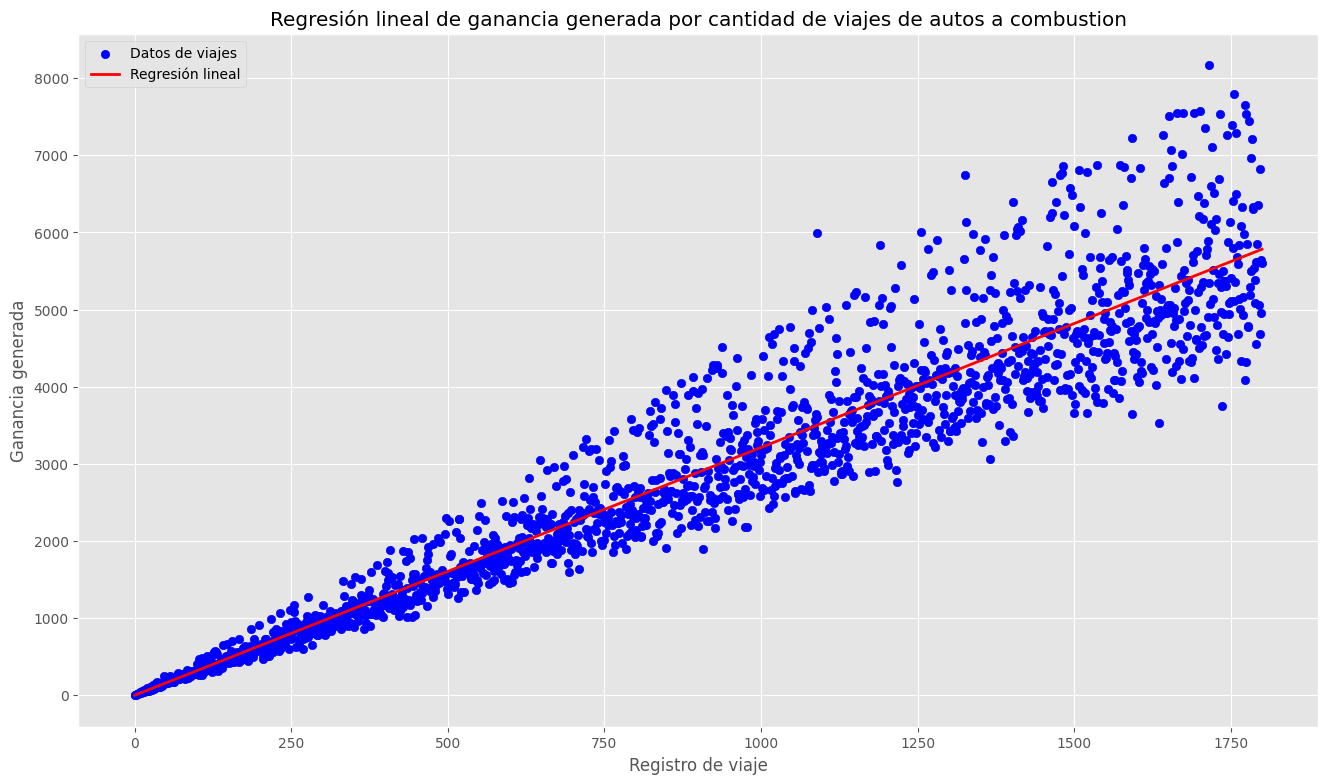

In [282]:
# Filtrar las filas que tienen el valor 'X' en la columna 'Fuel Type'
df_combustion = data_economica.loc[(data_economica['Fuel Type']== 'X') 
                                       |(data_economica['Fuel Type']== 'Z')]

df_combustion.reset_index(inplace=True)

# Aplicar la transformación logarítmica modificada a las emisiones de CO2
df_combustion['Ganancia_log'] = np.log1p(df_combustion['Ganancia'])

# Eliminar filas con valores NaN en 'Ganancia_log'
df_combustion.dropna(subset=['Ganancia_log'], inplace=True)

# Preparar los datos
X = df_combustion.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = df_combustion['Ganancia_log'].values * (df_combustion.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Convertir los valores transformados a la unidad original en gramos
y_original = np.expm1(y_pred)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Ganancia generada')
plt.title('Regresión lineal de ganancia generada por cantidad de viajes de autos a combustion')
plt.legend()
plt.show()

Regresión lineal simple para autos electricos:

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1366662437.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electricos['Ganancia_log'] = np.log1p(df_electricos['Ganancia'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1366662437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electricos.dropna(subset=['Ganancia_log'], inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1366662437.py:28: RuntimeWarning: overflow encountered in expm1
  y_original = np.expm1(y_pred)


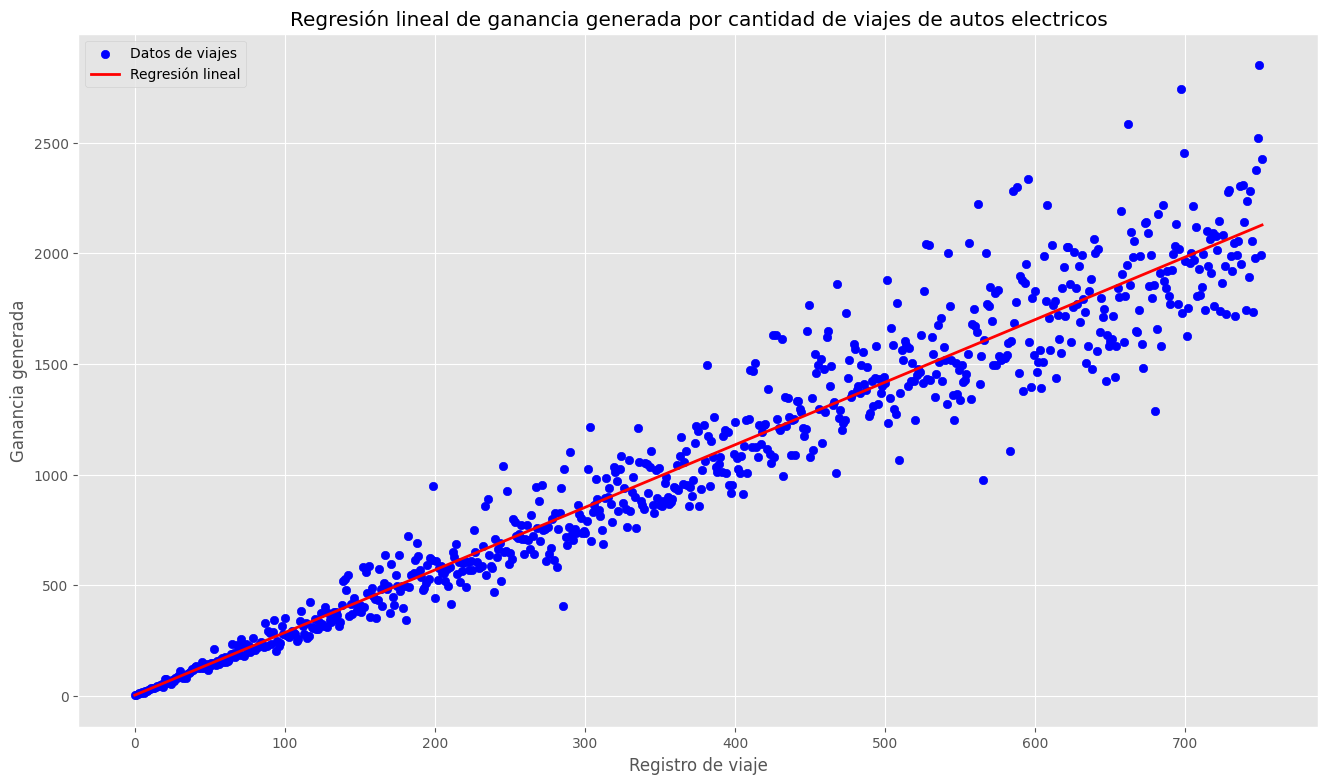

In [283]:
# Filtrar las filas que tienen el valor 'X' en la columna 'Fuel Type'
df_electricos = data_economica.loc[data_economica['Fuel Type']== 'B']

df_electricos.reset_index(inplace=True)

# Aplicar la transformación logarítmica modificada a las emisiones de CO2
df_electricos['Ganancia_log'] = np.log1p(df_electricos['Ganancia'])

# Eliminar filas con valores NaN en 'Ganancia_log'
df_electricos.dropna(subset=['Ganancia_log'], inplace=True)

# Preparar los datos
X = df_electricos.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = df_electricos['Ganancia_log'].values * (df_electricos.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Convertir los valores transformados a la unidad original en gramos
y_original = np.expm1(y_pred)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Ganancia generada')
plt.title('Regresión lineal de ganancia generada por cantidad de viajes de autos electricos')
plt.legend()
plt.show()

Regresión lineal simple para autos hibridos:

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1553391181.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hibridos['Ganancia_log'] = np.log1p(df_hibridos['Ganancia'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1553391181.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hibridos.dropna(subset=['Ganancia_log'], inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1553391181.py:28: RuntimeWarning: overflow encountered in expm1
  y_original = np.expm1(y_pred)


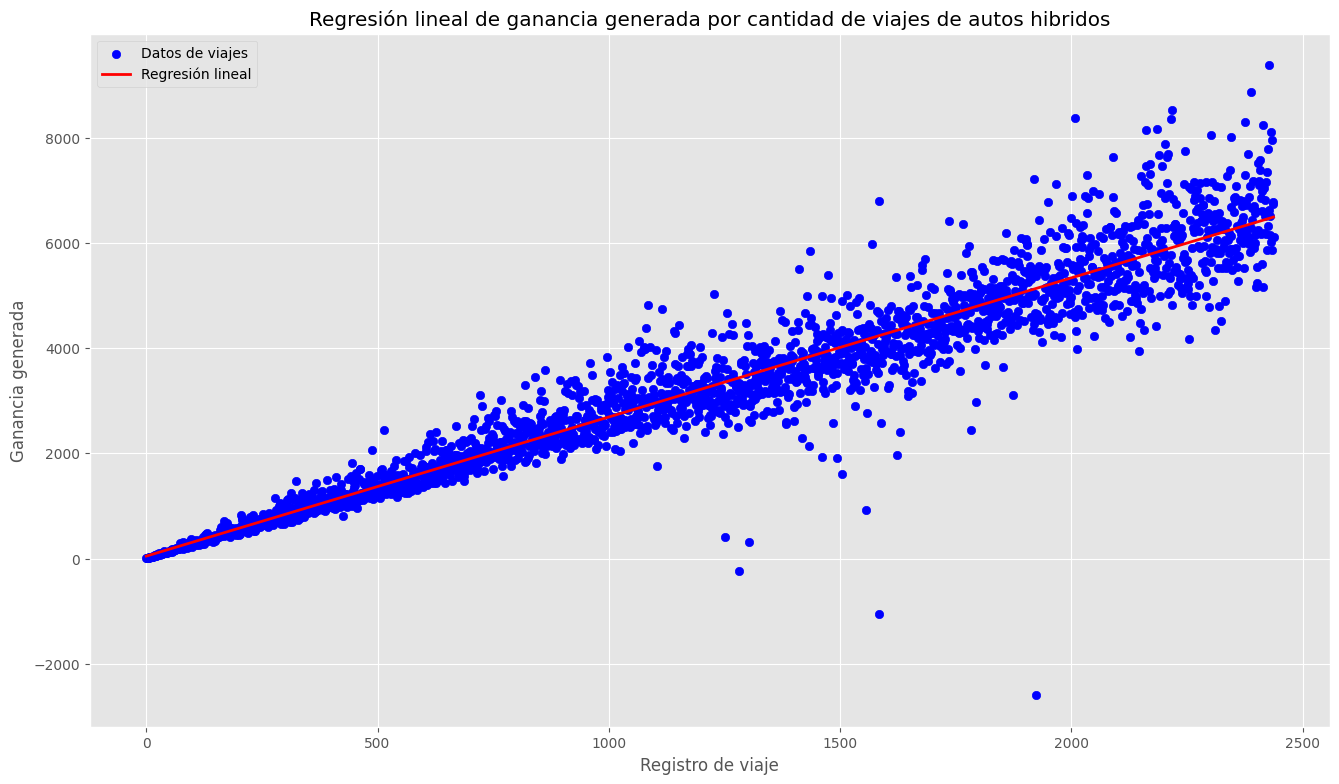

In [286]:
# Filtrar las filas que tienen el valor 'X' en la columna 'Fuel Type'
df_hibridos = data_economica.loc[data_economica['Fuel Type']== 'B/X*']

df_hibridos.reset_index(inplace=True)

# Aplicar la transformación logarítmica modificada a las emisiones de CO2
df_hibridos['Ganancia_log'] = np.log1p(df_hibridos['Ganancia'])

# Eliminar filas con valores NaN en 'Ganancia_log'
df_hibridos.dropna(subset=['Ganancia_log'], inplace=True)

# Preparar los datos
X = df_hibridos.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = df_hibridos['Ganancia_log'].values * (df_hibridos.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Convertir los valores transformados a la unidad original en gramos
y_original = np.expm1(y_pred)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Ganancia generada')
plt.title('Regresión lineal de ganancia generada por cantidad de viajes de autos hibridos')
plt.legend()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_14300\1892891909.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hibridos.dropna(subset=['Ganancia_log'], inplace=True)


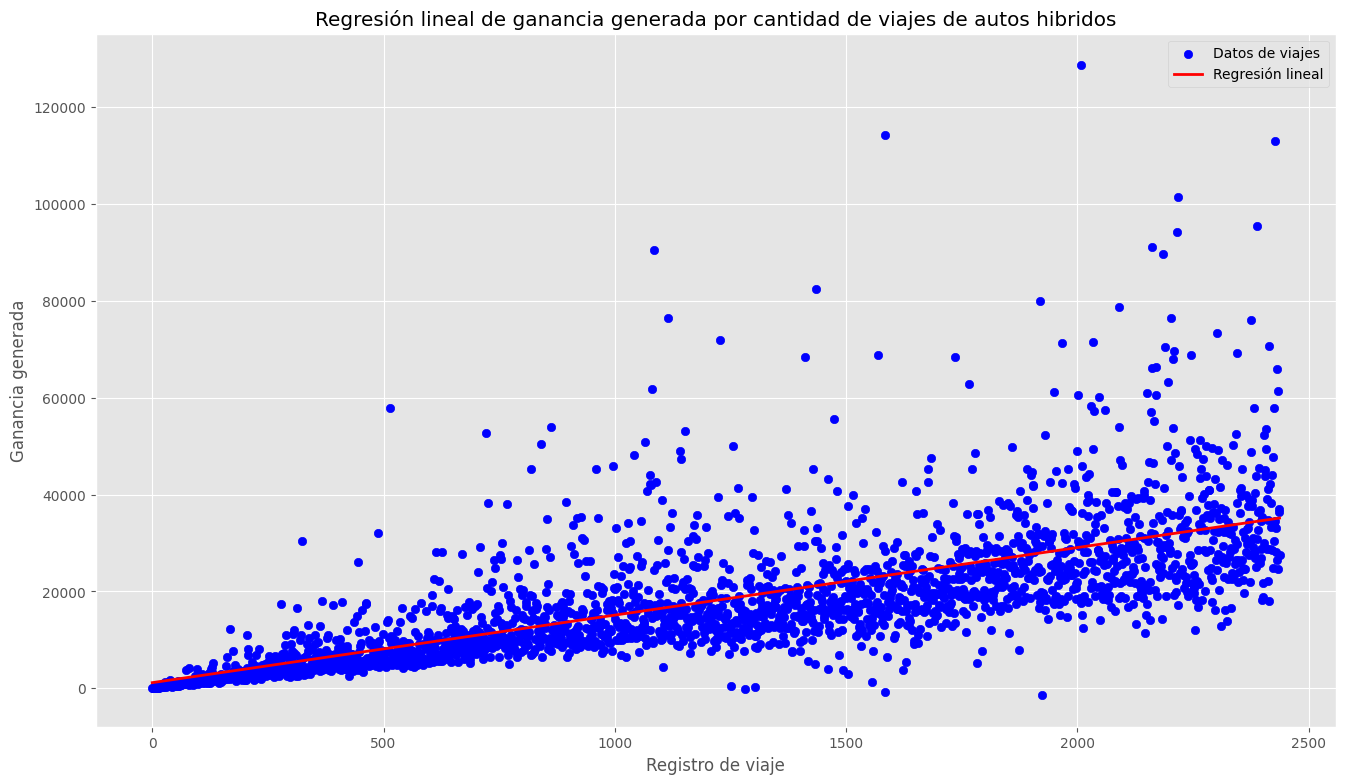

In [287]:
# Filtrar las filas que tienen el valor 'X' en la columna 'Fuel Type'
df_hibridos = data_economica.loc[data_economica['Fuel Type']== 'B/X*']

df_hibridos.reset_index(inplace=True)

# Aplicar la transformación logarítmica modificada a las emisiones de CO2
#df_hibridos['Ganancia_log'] = np.log1p(df_hibridos['Ganancia'])

# Eliminar filas con valores NaN en 'Ganancia_log'
df_hibridos.dropna(subset=['Ganancia_log'], inplace=True)

# Preparar los datos
X = df_hibridos.index.values.reshape(-1, 1)  # Variable independiente (número de fila)
y = df_hibridos['Ganancia'].values * (df_hibridos.index + 1)  # Variable dependiente (cantidad de emisiones de CO2 multiplicada por la cantidad de viajes)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X)

# Convertir los valores transformados a la unidad original en gramos
#y_original = np.expm1(y_pred)

# Visualizar los resultados en un gráfico de dispersión
plt.scatter(X, y, color='blue', label='Datos de viajes')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresión lineal')
plt.xlabel('Registro de viaje')
plt.ylabel('Ganancia generada')
plt.title('Regresión lineal de ganancia generada por cantidad de viajes de autos hibridos')
plt.legend()
plt.show()